# Imports

In [1]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.constants import EM_MU
from orbit_generation.processing import downsample_3d_array

In [2]:
import numpy as np
import os
import pandas as pd

In [3]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [4]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, f'exp{experiment_id}_corrected_initial_conditions.npy')
refined_data_file = os.path.join(experiment_folder, f'exp{experiment_id}_propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

In [5]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
synthetic_orbit_df = pd.DataFrame(initial_conditions, columns=columns)


In [6]:
generated_orbits = np.load(generated_data_path)
generated_orbits.shape

(100, 300, 7)

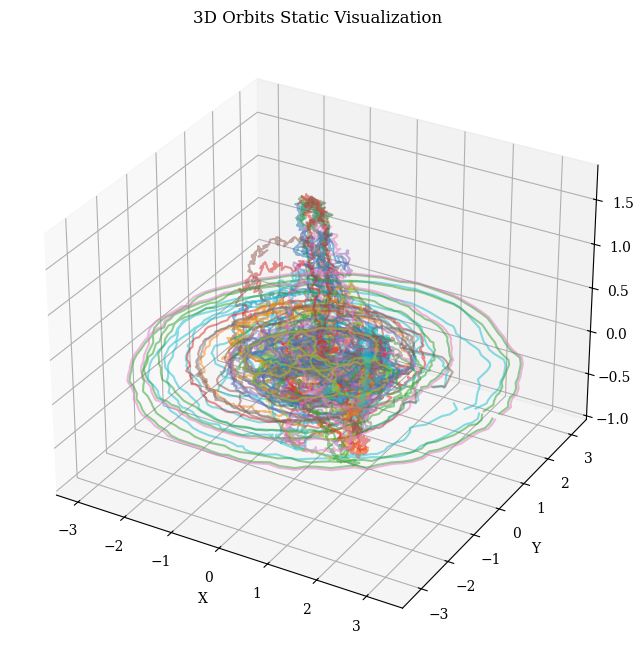

In [7]:
visualize_static_orbits(np.transpose(generated_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

In [8]:
refined_orbits = np.load(refined_data_file)
refined_orbits.shape

(51, 300, 7)

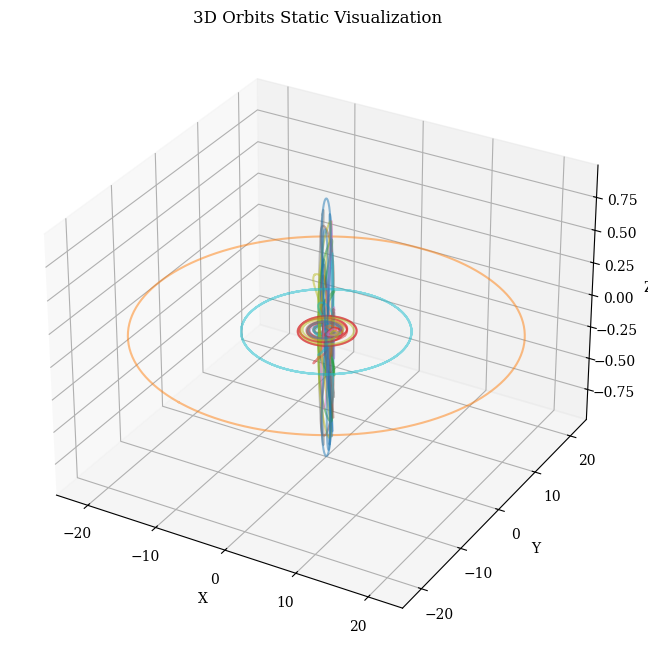

In [9]:
visualize_static_orbits(np.transpose(refined_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

# reshape and take 15n steps


In [10]:
#| export
#| hide
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main, JuliaError
import logging


In [35]:
#| export
Main.include("../julia/convergence_algorithm.jl")

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def differential_correction(
    orbit: np.ndarray,
    μ: float,
    variable_time: bool = True,
    time_flight: float = None,
    jacobi_constant: float = None,
    X_end: np.ndarray = None,
    tol: float = 1e-9,
    max_iter: int = 20,
    printout: bool = False,
    DX_0: np.ndarray = None,
    X_big_0: np.ndarray = None,
    δ: float = None
):
    """
    Wrapper for the Julia differential_correction function.
    
    Parameters:
        orbit (np.ndarray): Orbit data with shape [num_timesteps, 7].
        μ (float): Gravitational parameter.
        variable_time (bool): Whether to use variable time nodes.
        time_flight (float, optional): Total time of flight.
        jacobi_constant (float, optional): Jacobi constant.
        X_end (np.ndarray, optional): Terminal state vector (shape: [6]).
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.
        printout (bool): Whether to print iteration logs.
        DX_0 (np.ndarray, optional): Initial guess for state vector correction.
        X_big_0 (np.ndarray, optional): Auxiliary initial guess.
        δ (float, optional): Step size or perturbation parameter.

    Returns:
        tuple: (X_corrected, t_corrected, norm_F_or_G, iterations, success)
    """

    # Convert Python None to Julia 'nothing' using an empty list
    julia_time_flight = [] if time_flight is None else float(time_flight)
    julia_jacobi_constant = [] if jacobi_constant is None else float(jacobi_constant)
    julia_X_end = [] if X_end is None else Main.Vector(X_end.tolist())
    julia_DX_0 = [] if DX_0 is None else Main.Vector(DX_0.tolist())
    julia_X_big_0 = [] if X_big_0 is None else Main.Vector(X_big_0.tolist())
    julia_δ = [] if δ is None else float(δ)

    # Convert NumPy array to Julia array
    julia_orbit = Main.Matrix(orbit.tolist())

    # Call the Julia function
    result = Main.differential_correction(
        julia_orbit,
        μ,
        variable_time=variable_time,
        time_flight=julia_time_flight,
        jacobi_constant=julia_jacobi_constant,
        X_end=julia_X_end,
        tol=tol,
        max_iter=max_iter,
        printout=printout,
        DX_0=julia_DX_0,
        X_big_0=julia_X_big_0,
        δ=julia_δ
    )

    # Extract results from Julia tuples
    # Assuming the result is a tuple: (X_corrected, t_corrected, norm, iterations, success)
    X_corrected = np.array(result[0]).reshape(-1, 6)
    t_vec_corrected = np.array(result[1]).flatten()
    norm_F_or_G = float(result[2])
    iterations = int(result[3])
    success = int(result[4])

    return X_corrected, t_vec_corrected, norm_F_or_G, iterations, success

In [31]:
def process_orbits(
    orbit_array: np.ndarray, 
    μ: float, 
    variable_time: bool = True, 
    tol: float = 1e-9, 
    max_iter: int = 20, 
    printout: bool = False
):
    """
    Processes a set of orbits by providing the orbit array directly to differential correction.

    Parameters:
        orbit_array (np.ndarray): Array containing orbit data with shape [num_orbits, num_timesteps, 7].
                                   The first element in the last dimension is assumed to be time.
        μ (float): Gravitational parameter.
        variable_time (bool, optional): Whether to use variable time nodes for correction. Default is True.
        tol (float, optional): Tolerance for convergence in differential correction. Default is 1e-9.
        max_iter (int, optional): Maximum number of iterations for differential correction. Default is 20.
        printout (bool, optional): Whether to print iteration logs. Default is False.

    Returns:
        tuple: (converged_orbits_array, failed_orbit_indices_array)
               - converged_orbits_array: NumPy array with shape [num_converged_orbits, num_timesteps, 7] containing corrected orbits.
               - failed_orbit_indices_array: NumPy array with shape [num_failed_orbits] containing indices of orbits that failed to converge.
    """
    # Lists to store results
    converged_orbits_list = []
    failed_orbits_list = []
    
    num_orbits, num_timesteps, data_length = orbit_array.shape
    
    # Validate data_length
    if data_length != 7:
        logger.error("Data length is incorrect. Expected 7 elements (1 time + 6 state components).")
        raise ValueError("Data length is incorrect. Expected 7 elements (1 time + 6 state components).")
    
    # Loop over each orbit
    for i in range(num_orbits):
        logger.info(f"Processing orbit {i+1}/{num_orbits}")
        
        # Extract each orbit
        orbit = orbit_array[i]  # Shape: [num_timesteps, 7]

        # Apply differential correction
        try:
            X_corrected, t_corrected, norm_val, iterations, success_flag = differential_correction(
                orbit=orbit, 
                μ=μ, 
                variable_time=variable_time, 
                tol=tol, 
                max_iter=float(max_iter), 
                printout=printout
            )
        except Exception as e:
            logger.error(f"Orbit {i}: Differential correction failed with error: {e}")
            failed_orbits_list.append(i)
            continue

        logger.info(f"Orbit {i}: Success={success_flag}, Norm={norm_val}, Iterations={iterations}")
                
        # Check the success flag
        if success_flag == 1:  # Assuming success_flag == 1 indicates convergence
            # If successful, store the corrected orbit
            corrected_orbit = np.hstack((t_corrected[:, np.newaxis], X_corrected))
            converged_orbits_list.append(corrected_orbit)
        else:
            # If not successful, store the orbit index
            failed_orbits_list.append(i)

    # Convert lists to NumPy arrays
    if converged_orbits_list:
        converged_orbits_array = np.array(converged_orbits_list)
    else:
        converged_orbits_array = np.empty((0, num_timesteps, 7))

    failed_orbit_indices_array = np.array(failed_orbits_list)

    return converged_orbits_array, failed_orbit_indices_array

In [32]:
generated_orbits.shape

(100, 300, 7)

In [1]:
downsampled_orbits=downsample_3d_array(generated_orbits, axis=1, hop=30)
downsampled_orbits.shape

NameError: name 'downsample_3d_array' is not defined

In [34]:
converged_orbits, failed_orbits= process_orbits((downsampled_orbits), EM_MU)

INFO:__main__:Processing orbit 1/100
INFO:__main__:Calling Julia differential_correction function...
INFO:__main__:Julia differential_correction function completed successfully.
INFO:__main__:Orbit 0: Success=-1, Norm=11.962773764826661, Iterations=2
INFO:__main__:Processing orbit 2/100
INFO:__main__:Calling Julia differential_correction function...
INFO:__main__:Julia differential_correction function completed successfully.
INFO:__main__:Orbit 1: Success=-1, Norm=6.484355277300312, Iterations=20
INFO:__main__:Processing orbit 3/100
INFO:__main__:Calling Julia differential_correction function...
INFO:__main__:Julia differential_correction function completed successfully.
INFO:__main__:Orbit 2: Success=-1, Norm=15.010301567078965, Iterations=2
INFO:__main__:Processing orbit 4/100
INFO:__main__:Calling Julia differential_correction function...
INFO:__main__:Julia differential_correction function completed successfully.
INFO:__main__:Orbit 3: Success=-1, Norm=49.84485842972675, Iterations

In [ ]:
converged_orbits.shape

In [ ]:
visualize_static_orbits(np.transpose(converged_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

In [ ]:
refined_orbits.shape

In [ ]:
visualize_static_orbits(np.transpose(refined_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

In [ ]:
klk

In [38]:
converged_orbits.shape

(53, 20, 7)

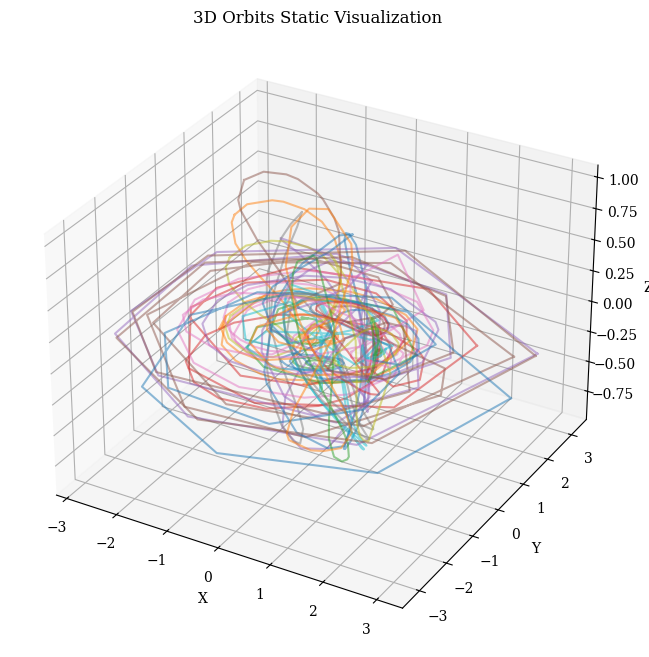

In [39]:
visualize_static_orbits(np.transpose(converged_orbits[:,:,1:], (0, 2, 1)), show_legend=False)

In [ ]:
visualize_static_orbits(np.transpose(refined_orbits[:,:,1:], (0, 2, 1)), show_legend=False)